In [1]:
#Skalowanie daje slabe wyniki, bez skalowania jest duzo lepiej
#batch normalization polepszylo znaczaco wyniki
#

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
tf.get_logger().setLevel('INFO')
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv1D, Conv1DTranspose, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, MSE
# import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from datetime import datetime
# from keras import backend as K
from tensorflow.keras.utils import plot_model
from mpl_toolkits.mplot3d import Axes3D
# import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

# Generate data

In [4]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)
    

In [5]:
n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Scale data

In [6]:
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

In [7]:
# scaler = StandardScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)

# Plot data

4000


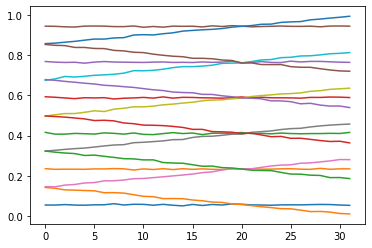

In [8]:
plot_lines = np.concatenate((x_train[1000:1010], x_train[11000:11010], x_train[21000:21010], x_train[31000:31010],x_train[41000:41010],x_train[51000:51010])) 
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Create model

In [17]:
original_dim = 32
intermediate_dim = 16
batch_size = 128
latent_dim = 8
epochs = 1
kernel_size = 4
filters = 8
stride = 2

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=0.1)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
#ENCODER
inputs = Input(shape=(original_dim, 1), name='encoder_input')
x = Conv1D(filters, kernel_size, activation='relu', padding='valid', strides=stride, name='encoder_conv1D')(inputs)
x = BatchNormalization()(x)
shape = K.int_shape(x)
x = Flatten(name='encoder_flattener')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

#DECODER
latent_inputs = Input(shape=(latent_dim, ), name='z_sampling')
x = Dense(shape[1] * shape[2], name='decoder_deflattener')(latent_inputs)
x = Reshape((shape[1], shape[2]), name='decoder_reshaper')(x)
x = Conv1DTranspose(filters, kernel_size, activation='relu', padding='valid', strides=stride, name='decoder_conv1D')(x)
x = BatchNormalization()(x)
outputs = Conv1DTranspose(1, 8, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

#VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
encoder_conv1D (Conv1D)         (None, 15, 8)        40          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 15, 8)        32          encoder_conv1D[0][0]             
__________________________________________________________________________________________________
encoder_flattener (Flatten)     (None, 120)          0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [19]:
models = (encoder, decoder)
reconstruction_loss = MSE(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (1 * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.summary()

# Learn data

In [20]:
for i in range(10):
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size)
    z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
    print(f"{davies_bouldin_score(z_mean, y_train)} Davies-Boulding Score") # The lower the better
    # print(f"{silhouette_score(z_mean, y_train)} Silhouette Score")
    print(f"{calinski_harabasz_score(z_mean, y_train)} Calinski-Harabasz Score") # The higher the better
    

500/500 [==============================] - 2s 5ms/step - loss: 0.4729
4.5140566574486565 Davies-Boulding Score
3119.8437445182553 Calinski-Harabasz Score
238/500 [=============>................] - ETA: 1s - loss: 0.2643

KeyboardInterrupt: 

In [ ]:
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
print(f"{davies_bouldin_score(z_mean, y_train)} Davies-Boulding Score") # The lower the better
# print(f"{silhouette_score(z_mean, y_train)} Silhouette Score")
print(f"{calinski_harabasz_score(z_mean, y_train)} Calinski-Harabasz Score") # The higher the better
z_mean = PCA(n_components=2).fit_transform(z_mean)

fig = plt.figure(figsize=(12,10))
plt.scatter(z_mean[:, 0], z_mean[:, 1],  c=y_train)

In [ ]:
res = vae.predict(x_train, batch_size=128)
plt.figure(figsize=(20,12))
index = 10
interval = int(n_lines / n_types)
while index < n_lines:
    for i in range(index, index + 10, 1):
        plt.plot(res[i], c=y_train[i])
    index += interval

In [ ]:
res = vae.predict(x_train, batch_size=128)
index = 10
interval = int(n_lines / n_types)
while index < n_lines:
    plt.figure(figsize=(20,12))
    plt.grid()
    plt.ylim((0,1))
    for i in range(index, index + 400, 1):
        plt.plot(res[i], c=y_train[i])
    index += interval